
# Cross Analysis Between Properties of Canadian Cheese Varieties and Provincial Climates



## CSFDataAnalysisInternshipAssessment2025



## Overview


This notebook seeks to detail the analysis of the potential relationship between provincial climate regions and the proprties of the cheese that is produced within these regions across a variety of factors, including: moisture and fat levels, manufacturing and treatment type, firmness, milk type, and organicity. 


## Datasets Considered


Two open source datasets were considered for analysis: 

1. https://www.kaggle.com/datasets/noahjanes/canadian-cheese-directory/data
2. https://www.kaggle.com/datasets/hemil26/canada-weather

An alternative dataset regarding Canadian provincial weather (https://www.kaggle.com/datasets/sarahquesnelle/canada-data) was offered for use, but was disregarded in favour of the aformentioned selection due to the following reasons: 

1. The sheer amount of data points aggreated would present some difficulties to work with in a small-scale analysis
2. The data  was aggregated across months for every province, since the year 1917. Given that climate patterns may change overtime, and with insubstantial information as to when the data in the Canadian cheese directory was aggregated exactly, it is possible that using this dataset might have lead to considering climate data that is not necessarily relevant. 

In [212]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



## Original Datasets


In [213]:
cheese_df = pd.read_csv("canada_cheese_directory - Sheet1.csv")
weather_df = pd.read_csv("canada_weather_directory - Sheet1.csv")

cheese_df.head(), weather_df.head()


(   CheeseId ManufacturerProvCode ManufacturingTypeEn  MoisturePercent  \
 0       228                   NB           Farmstead             47.0   
 1       242                   NB           Farmstead             47.9   
 2       301                   ON          Industrial             54.0   
 3       303                   NB           Farmstead             47.0   
 4       319                   NB           Farmstead             49.4   
 
                                           FlavourEn  \
 0                                     Sharp, lactic   
 1                Sharp, lactic, lightly caramelized   
 2                           Mild, tangy, and fruity   
 3  Sharp with fruity notes and a hint of wild honey   
 4                                      Softer taste   
 
                                    CharacteristicsEn  Organic  \
 0                                           Uncooked        0   
 1                                           Uncooked        0   
 2  Pressed and co


## Data Preparation 


The data was prepared and cleaned in a number of ways for ease-of analysis.

### Climate Data 

The Canadian weather dataset contains values for annual high and low temperatures, as well as high and low temperatures for the months of January and July; these scores were taken across multiple regions in a given province. As we are interested in overall temperatures per province, the following steps were taken: 
1. Data was (arbitrarily) encoded as only farenheit for ease of data processing.
2. Data for janurary and July measurements were discarded.
3. For provinces with multiple figures across different regions within the province, the data was averaged such that overall annual high and low figures were generated per province.
4. The aformentioned high and low scores were averaged to achieve a single overall temperature figure for each province.

In [214]:
# Extract only necessary columns
weather = weather_df[['Community', 'Annual(Avg. high °C (°F))', 'Annual(Avg. low °C (°F))']].copy()

# Extract province from Community
weather['Province'] = weather['Community'].str.extract(r',\s*(\w{2})$')

# Extract Fahrenheit values
weather['Annual High (F)'] = weather['Annual(Avg. high °C (°F))'].str.extract(r'\(([-\d\.]+)\)').astype(float)
weather['Annual Low (F)'] = weather['Annual(Avg. low °C (°F))'].str.extract(r'\(([-\d\.]+)\)').astype(float)

# Average by Province
weather_avg = weather.groupby('Province')[['Annual High (F)', 'Annual Low (F)']].mean().reset_index()
weather_avg['Annual Avg Temp (F)'] = weather_avg[['Annual High (F)', 'Annual Low (F)']].mean(axis=1)

weather_avg.head()


,Province,Annual High (F),Annual Low (F),Annual Avg Temp (F)
0,AB,47.166667,25.933333,36.550000
1,BC,54.020000,35.720000,44.870000
2,MB,37.900000,18.466667,28.183333
3,NB,50.966667,30.566667,40.766667
4,NL,43.833333,29.400000,36.616667


### Canadian Cheese Data

The Canadian cheese directory contains data for a variety of cheeses across a range of metrics, upto and including: CheeseID, ManufacturingLocation, ManufacturingType, MoisturePercentage, Flavour Profile, Specific Characteristics, Fat levels, Organicity, Firmness, MilkType, and TreatmentType. Of these, only a handful were chosen for analysis. Data on cheese flavour profile and specific characteristics were dropped, as the data was overly varied and likely to be dependant on the specific cheese variety it pertained to, rather than indicative of greater trends in the data. Rind type was discarded due to a largely incomplete/missing set of values 

In [215]:
# Select relevant columns
cheese_df = cheese_df[['CheeseId', 'ManufacturerProvCode', 'MoisturePercent', 'FatLevel', 'CategoryTypeEn',
                       'CheeseName', 'MilkTypeEn', 'MilkTreatmentTypeEn', 'ManufacturingTypeEn', 'Organic']]

# Strip any whitespace from column names
cheese_df.columns = cheese_df.columns.str.strip()

cheese_df.head()


,CheeseId,ManufacturerProvCode,MoisturePercent,FatLevel,CategoryTypeEn,CheeseName,MilkTypeEn,MilkTreatmentTypeEn,ManufacturingTypeEn,Organic
0,228,NB,47.0,lower fat,Firm Cheese,Sieur de Duplessis (Le),Ewe,Raw Milk,Farmstead,0
1,242,NB,47.9,lower fat,Semi-soft Cheese,Tomme Le Champ Doré,Cow,Raw Milk,Farmstead,0
2,301,ON,54.0,lower fat,Firm Cheese,Provolone Sette Fette (Tre-Stelle),Cow,Pasteurized,Industrial,0
3,303,NB,47.0,lower fat,Veined Cheeses,Geai Bleu (Le),Cow,Raw Milk,Farmstead,0
4,319,NB,49.4,lower fat,Semi-soft Cheese,Gamin (Le),Cow,Raw Milk,Farmstead,1


### Merge Weather with Cheese Data

The final prepared datasets were merged such that the cheese directory contained an extra column containing average temperature figures pertaining to the province the cheese was produced in. Following this, entries were numerically ordered in ascending order by provincial temperatures. 

In [216]:
# Merge on province
merged_df = cheese_df.merge(weather_avg, left_on='ManufacturerProvCode', right_on='Province', how='left')

# Sort by temperature
merged_sorted = merged_df.sort_values(by='Annual Avg Temp (F)').reset_index(drop=True)

merged_sorted.head()


,CheeseId,ManufacturerProvCode,MoisturePercent,FatLevel,CategoryTypeEn,CheeseName,MilkTypeEn,MilkTreatmentTypeEn,ManufacturingTypeEn,Organic,Province,Annual High (F),Annual Low (F),Annual Avg Temp (F)
0,807,MB,37.0,higher fat,Firm Cheese,Cheddar (Bothwell),Cow,Pasteurized,Farmstead,1,MB,37.9,18.466667,28.183333
1,2086,MB,42.0,lower fat,NaN,Muenster (Bothwell),Cow,NaN,Farmstead,0,MB,37.9,18.466667,28.183333
2,1845,MB,44.0,lower fat,Semi-soft Cheese,Mozzarella (Bothwell),Cow,Pasteurized,Farmstead,0,MB,37.9,18.466667,28.183333
3,1844,MB,42.0,lower fat,Firm Cheese,Black Truffle,Cow,Pasteurized,Farmstead,0,MB,37.9,18.466667,28.183333
4,1843,MB,42.0,lower fat,Firm Cheese,Red Hot Chili Pepper Jack,Cow,Pasteurized,Farmstead,0,MB,37.9,18.466667,28.183333


In [217]:
# Saving the final prepared dataset
merged_sorted.to_csv("cheese_sorted_by_temperature.csv", index=False)
print("Saved to cheese_sorted_by_temperature.csv")


Saved to cheese_sorted_by_temperature.csv


## 📊 Findings, Figures and Analysis

### Summary

Overall, it can be seen that provincial temperatures do not seem to have any significant effect or correlation to the properties of the cheese produced within the given region, or at the very least, not across the metrics presented within this dataset. While some correlations can be observed between provincial temperatures and certain factors, they are of weak strength; it cannot be said whether the correlations observed are indicative of any greater/meaningful relationship, or simply a consequence of weaknesses in the data itself.

### Figures

### Figure 1. Provincial Temperatures and Cheese Moisture Percentages

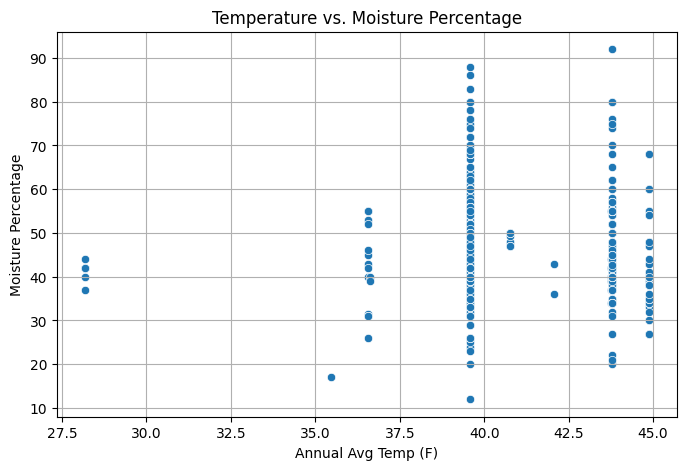

In [218]:
# Convert to numeric
merged_sorted['MoisturePercent'] = pd.to_numeric(merged_sorted['MoisturePercent'], errors='coerce')
merged_sorted['Organic'] = pd.to_numeric(merged_sorted['Organic'], errors='coerce')

# Scatter plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.scatterplot(data=merged_sorted, x='Annual Avg Temp (F)', y='MoisturePercent')
plt.title("Temperature vs. Moisture Percentage")
plt.xlabel("Annual Avg Temp (F)")
plt.ylabel("Moisture Percentage")
plt.grid(True)
plt.show()


As can be seen in the figure above, there seems to be no clear trend between provincial temperature and cheese moisture content. While data represenation largely skews towards warmer regions, these regions produce cheese containing a variety of moisture contents. 

### Figure 2. Provincial Temperatures and Cheese Fat Levels

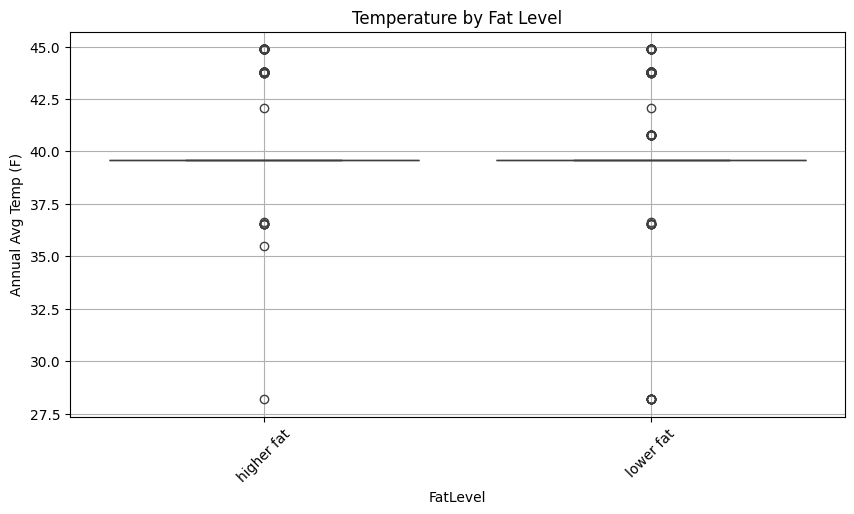

In [219]:
# Fat Level
plt.figure(figsize=(10, 5))
sns.boxplot(data=merged_sorted, x='FatLevel', y='Annual Avg Temp (F)')
plt.title("Temperature by Fat Level")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Minimal differneces among the distribution of the mean and outliers between the two groups suggests that differnces in provincial temperature has minimal/negligible effect on wether a cheese produced is organic or not.

### Figure 3. Provincial Temperatures and Cheese Firmness

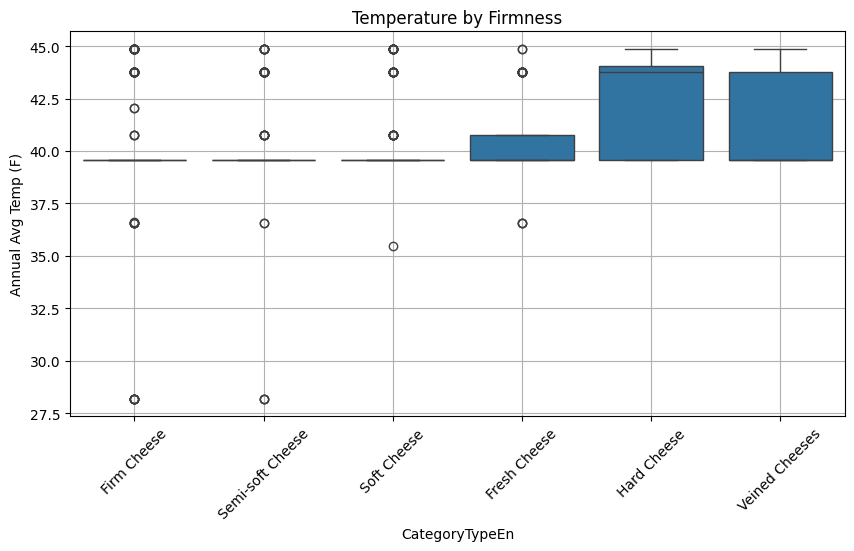

In [220]:
# Firmness (Category Type)
plt.figure(figsize=(10, 5))
sns.boxplot(data=merged_sorted, x='CategoryTypeEn', y='Annual Avg Temp (F)')
plt.title("Temperature by Firmness")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

The overall uniformity among the categories of cheeses suggests that provincial temperatures do not effect the firmness of Canadian cheese varieties. While hard cheeses do see higher representation amongst warmer climate regions in Canada when compared to other categories, this difference is minimal. 

### Figure 4. Provincial Temperatures and Cheese Manafacturing Type

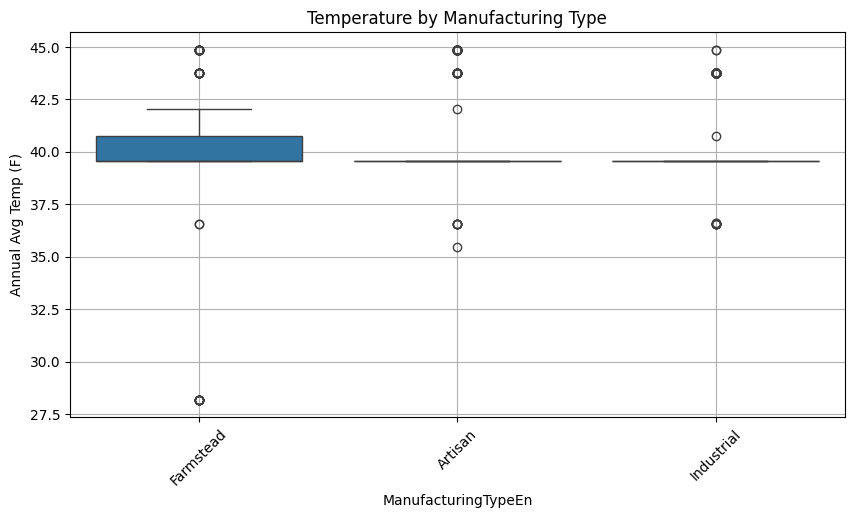

In [221]:
# Manufacturing Type
plt.figure(figsize=(10, 5))
sns.boxplot(data=merged_sorted, x='ManufacturingTypeEn', y='Annual Avg Temp (F)')
plt.title("Temperature by Manufacturing Type")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Farmstead produced cheeses bear minimally greater presence in colder climates, whereas industrially produced cheeses generally span a variety of temperature zones.

### Figure 5. Provincial Temperatures and Milk Treatment Type

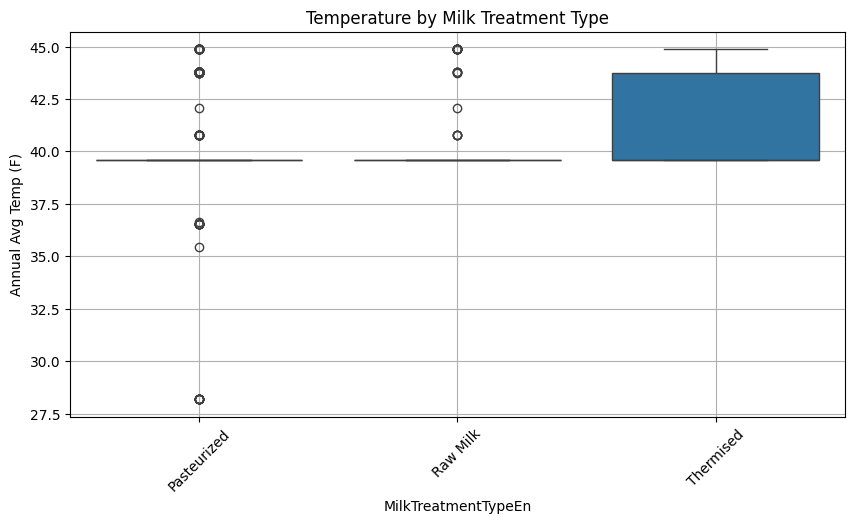

In [222]:
# Milk Treatment Type
plt.figure(figsize=(10, 5))
sns.boxplot(data=merged_sorted, x='MilkTreatmentTypeEn', y='Annual Avg Temp (F)')
plt.title("Temperature by Milk Treatment Type")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Some presence of outliers suggests Canadian cheeses made from pasteurized milk have a miniamlly greater variation across temperature ranges, whereas cheeses made from raw milk are similarly concentrated to warmer climates. Cheeses made from thermized milk bear an overall greater association to warmer climate regions. These findings may be due to chance outlier presence or sparse data, or potentially province specific regulation on the production/distribtuiion of raw milk and thermized cheeses. 

### Figure 6. Provincial Temperatures and Cheese Organicity

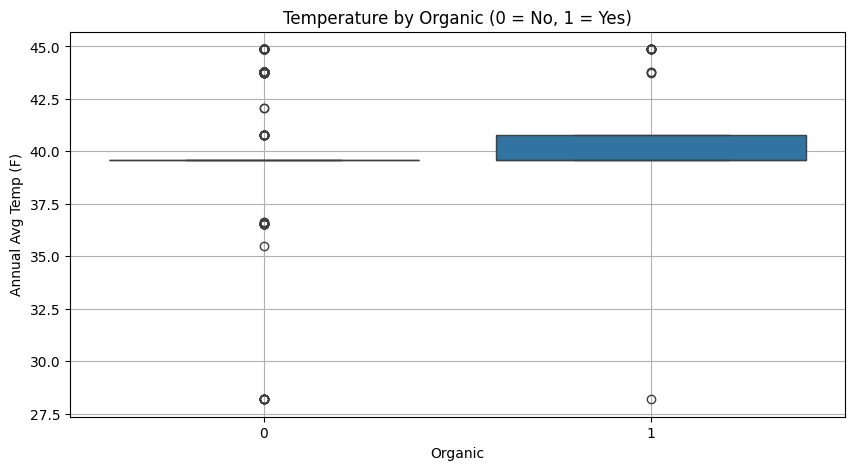

In [223]:
# Organic
plt.figure(figsize=(10, 5))
sns.boxplot(data=merged_sorted, x='Organic', y='Annual Avg Temp (F)')
plt.title("Temperature by Organic (0 = No, 1 = Yes)")
plt.grid(True)
plt.show()

Organic cheeses seem somewhat skewed to warmer provinces, however this difference is neglible, likely a result of organic cheeses simply being more present within the data.

### Figure 7. Provincial Temperatures and Milk Type

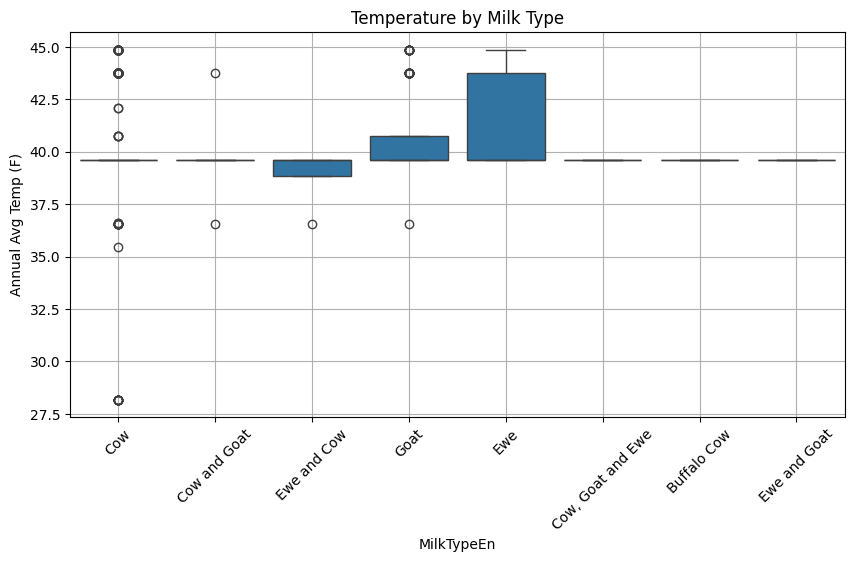

In [224]:
# Milk Type
plt.figure(figsize=(10, 5))
sns.boxplot(data=merged_sorted, x='MilkTypeEn', y='Annual Avg Temp (F)')
plt.title("Temperature by Milk Type")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Cow's milk, goat's milk, and sheep's milk (ewe) cheeses all have some manner presence across a variety of climate regions. Combined type cheeses do not possess enough data to make substantial figures or conclusions. 

## 🔢 Correlation Matrix

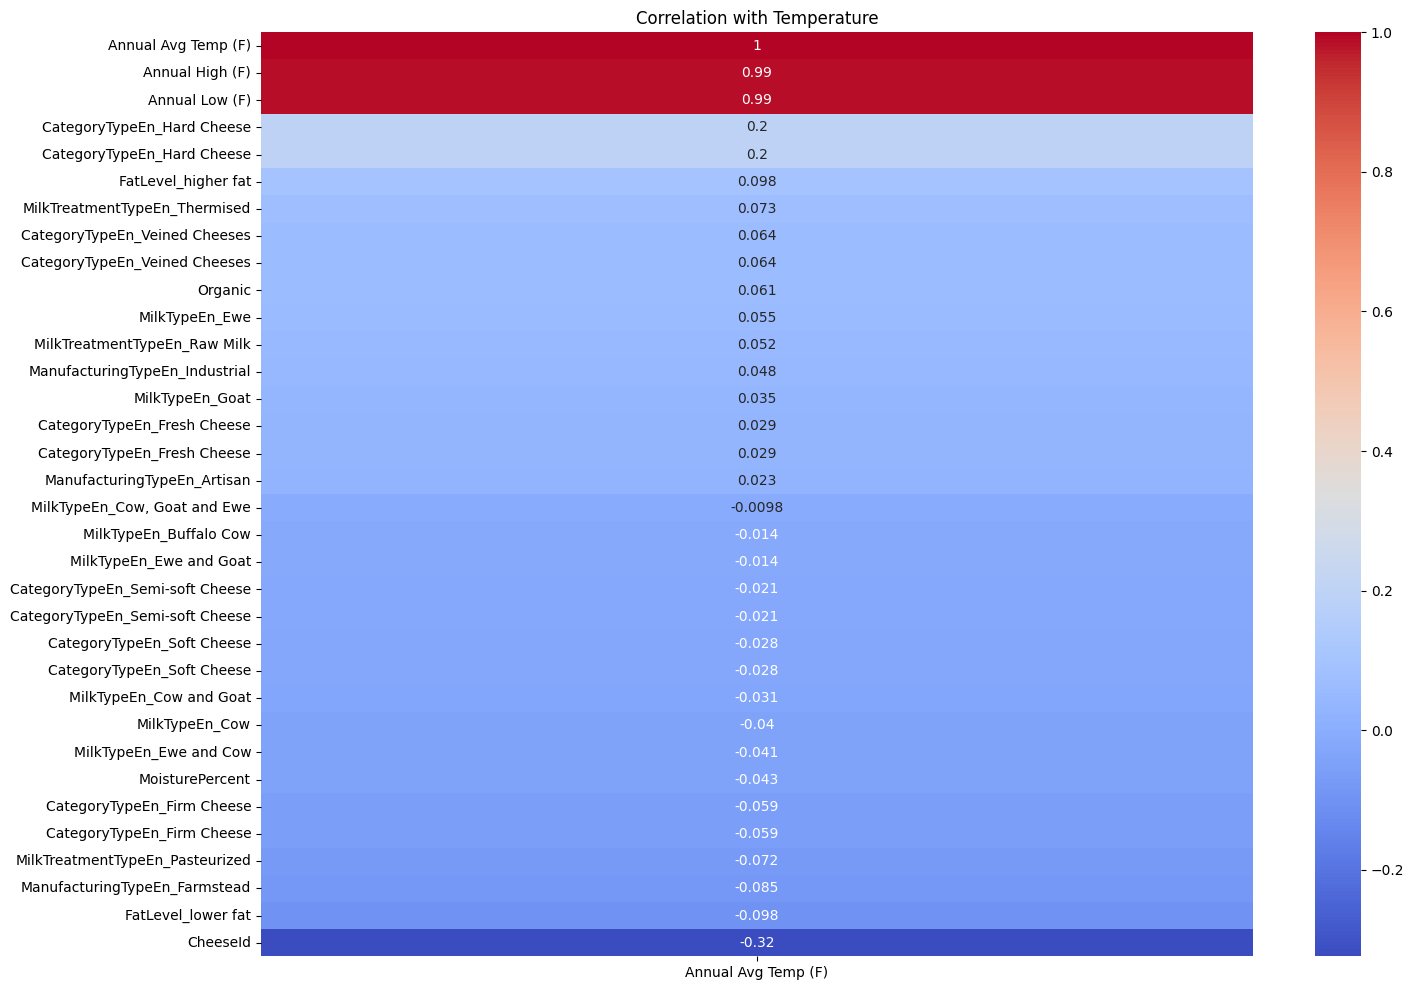

In [225]:
# One-hot encode categorical columns
categorical_cols = ['FatLevel', 'CategoryTypeEn', 'CategoryTypeEn', 'ManufacturingTypeEn', 'MilkTreatmentTypeEn', 'MilkTypeEn']
df_encoded = pd.get_dummies(merged_sorted, columns=categorical_cols)

# Correlation matrix (ensure issues do not arise with non numeric values)
# Drop irrelevant columns from correlation matrix
drop_cols = ['CheeseId', 'Annual High (F)', 'Annual Low (F)', 'Annual Avg Temp (F)']
df_corr = df_encoded.drop(columns=[col for col in drop_cols if col in df_encoded.columns], errors='ignore')
correlation_matrix = df_corr.corr(numeric_only=True)

# Show correlation with temperature
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix[['Annual Avg Temp (F)']].sort_values(by='Annual Avg Temp (F)', ascending=False),
            annot=True, cmap='coolwarm')
plt.title("Correlation with Temperature")
plt.show()


The figure above details a correlation matrix displaying the correlational strength between provincial temperatures and individual metrics in the Canadian cheese directory dataset. This shows that all metrics fall into the zone of weak to no linear correlation (0.2 or below).

Note: cheeseid and temperature measurements themselves are included in the above matrix despite not being metrics measured in the dataset. This is simply to provide color contrast/a sense of comparsion between the weak correlation regions in the matrix

## Discussion

In summation, this limited, small-scale cross analysis reveals that there seems to be no meanifnful relationship between provincial temperature regions, and the Canadian cheese varieties produced within said regions. While some correlation can be obverved among certain metrics, this correlaton is overwhelmingly weak. 

This being said, it is highly likely that a majority of the findings from this analysis are a result of limitations within the dataset  itself, rather than a result of the presence (or lack thereof) of meaningful co-variate relationsips. For example, viewers may notice that among a majority of the figures, the mean scores for most of the metrics tend around 40 degrees farenheit in terms of provincial climate. This is likely due to the fact that a majority of all Canadian cheese production takes place in Quebec (Shahbandeh, 2024), which has an annual average temperature of approximately 40 degrees farenheit. This overhwelming presence potentially skews the data, making it harder to ascertain the effects of other provincial climate regions on the properties of cheese produced. In the future, perhaps datasets with greater variation/region representivity may yield more substantial findings. 

## External Sources 

Shahbandeh, M. (2024, February 15). Cheese: Production volume by Province in Canada 2019. Statista. https://www.statista.com/statistics/725365/volume-of-cheese-produced-by-province-canada/#statisticContainer

Janes, N. (2024, September 18). Canadian Cheese Directory. Kaggle. https://www.kaggle.com/datasets/noahjanes/canadian-cheese-directory/data 

hemil26. (2022, February 21). Canada weather. Kaggle. https://www.kaggle.com/datasets/hemil26/canada-weather 

Quesnelle, S. (2023, March 26). Canada temperatureerature dataset. Kaggle. https://www.kaggle.com/datasets/sarahquesnelle/canada-data 